In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'
DS_LIST = ['facs', 'droplet']

# Score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.magma_10kb_1000',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                  'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet_with_cov.tcell_sig'}

DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST = {'facs': ['PASS_IBD'], 
                  'droplet': ['PASS_IBD'], 
                  'facs_tsig': ['naive_cd4', 'memory_cd4', 'effector_cd4', 
                                'reg_cd4', 'naive_cd8', 'memory_cd8', 'effector_cd8'], 
                  'droplet_tsig': ['naive_cd4', 'memory_cd4', 'effector_cd4', 
                                'reg_cd4', 'naive_cd8', 'memory_cd8', 'effector_cd8']}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Get data for only T cells and rerun harmony+umap

facs


2021-05-16 20:57:23,950 - harmonypy - INFO - Iteration 1 of 20
2021-05-16 20:57:25,104 - harmonypy - INFO - Iteration 2 of 20
2021-05-16 20:57:26,110 - harmonypy - INFO - Iteration 3 of 20
2021-05-16 20:57:26,721 - harmonypy - INFO - Iteration 4 of 20
2021-05-16 20:57:27,481 - harmonypy - INFO - Iteration 5 of 20
2021-05-16 20:57:27,995 - harmonypy - INFO - Iteration 6 of 20
2021-05-16 20:57:28,460 - harmonypy - INFO - Iteration 7 of 20
2021-05-16 20:57:28,924 - harmonypy - INFO - Iteration 8 of 20
2021-05-16 20:57:29,390 - harmonypy - INFO - Iteration 9 of 20
2021-05-16 20:57:29,904 - harmonypy - INFO - Iteration 10 of 20
2021-05-16 20:57:30,418 - harmonypy - INFO - Iteration 11 of 20
2021-05-16 20:57:30,883 - harmonypy - INFO - Iteration 12 of 20
2021-05-16 20:57:32,037 - harmonypy - INFO - Iteration 13 of 20
2021-05-16 20:57:32,501 - harmonypy - INFO - Iteration 14 of 20
2021-05-16 20:57:33,014 - harmonypy - INFO - Iteration 15 of 20
2021-05-16 20:57:33,429 - harmonypy - INFO - Iter

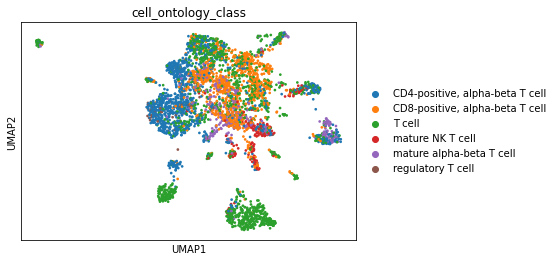

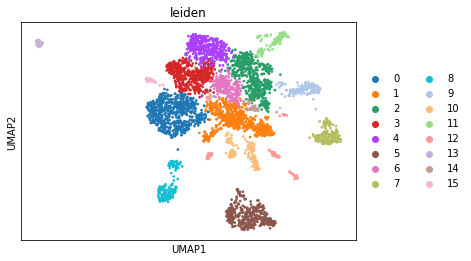

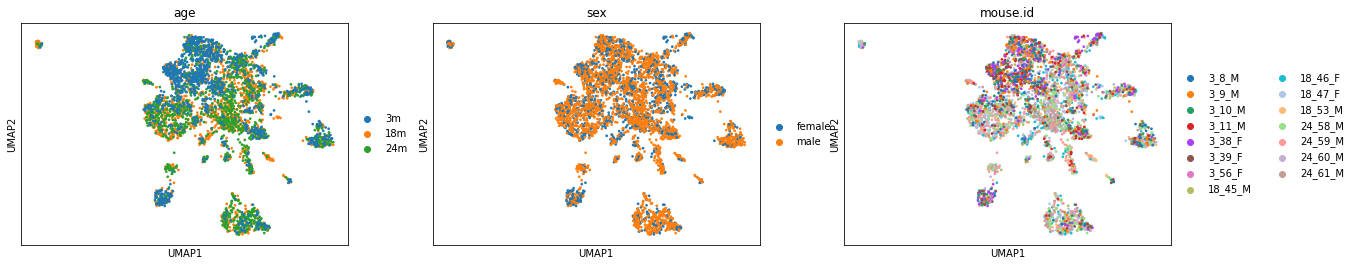

droplet


2021-05-16 20:58:05,569 - harmonypy - INFO - Iteration 1 of 20
2021-05-16 20:58:12,367 - harmonypy - INFO - Iteration 2 of 20
2021-05-16 20:58:19,137 - harmonypy - INFO - Iteration 3 of 20
2021-05-16 20:58:25,923 - harmonypy - INFO - Converged after 3 iterations
... storing 'tissue_celltype' as categorical


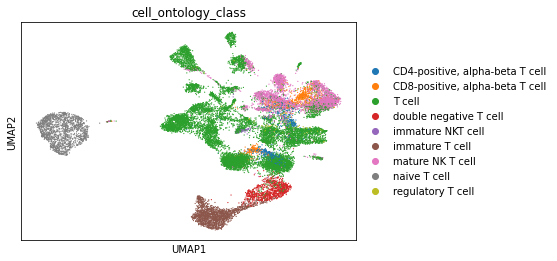

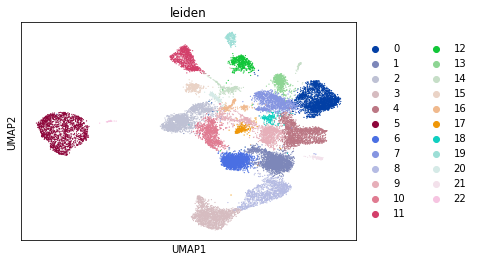

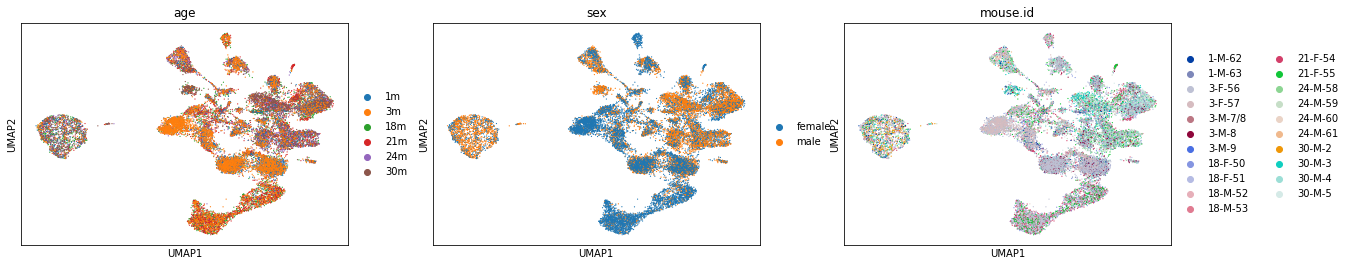

In [5]:
# Reprocess t cell data
dic_data_proc = {}
for ds in DS_LIST:
    print(ds)
    ind_select = [('T cell' in x)  for x in dic_data_raw[ds].obs['tissue_celltype']]
    adata = dic_data_raw[ds][ind_select,:].copy()
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
    adata.obs['batch_harmony'] = adata.obs['mouse.id']
    adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
    sc.tl.leiden(adata, resolution=0.7)   
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cell_ontology_class')
    sc.pl.umap(adata, color='leiden')
    sc.pl.umap(adata, color=['age', 'sex', 'mouse.id'])
    adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                'tcell.%s.h5ad'%ds)

### Annotate tcell.facs.h5ad data

In [5]:
dic_data_proc = {}
for ds in ['facs', 'droplet']:   
    dic_data_proc[ds] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                  'tms_proc/tcell.%s.h5ad'%ds)

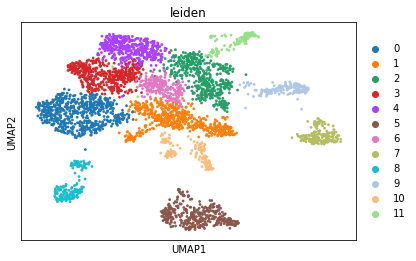

In [6]:
# Annotation info: cluster label
adata = dic_data_proc['facs'].copy()
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
sc.pl.umap(adata[adata.obs['leiden'].isin(cluster_list)], color='leiden')

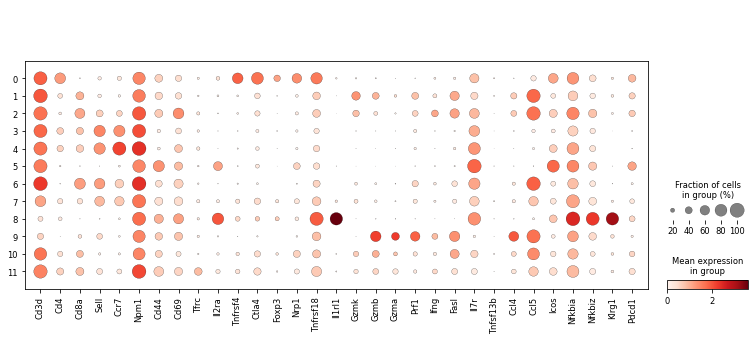

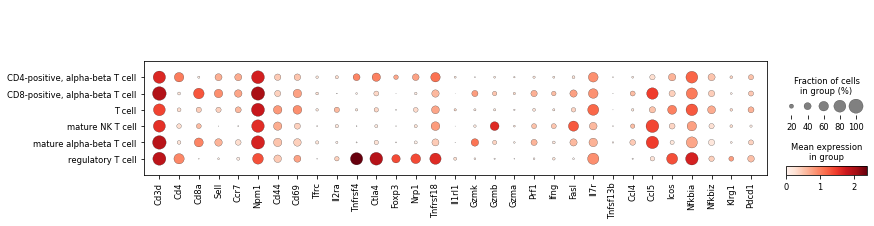

cell
leiden cell_ontology_class                   
0      CD4-positive, alpha-beta T cell  486.0
       T cell                            74.0
       regulatory T cell                 41.0
1      CD4-positive, alpha-beta T cell   52.0
       CD8-positive, alpha-beta T cell  211.0
       T cell                            71.0
       mature NK T cell                  78.0
       mature alpha-beta T cell         147.0
2      CD4-positive, alpha-beta T cell   30.0
       CD8-positive, alpha-beta T cell  310.0
       T cell                           159.0
3      CD4-positive, alpha-beta T cell  236.0
       CD8-positive, alpha-beta T cell  158.0
       T cell                            53.0
       mature alpha-beta T cell          36.0
4      CD4-positive, alpha-beta T cell  126.0
       CD8-positive, alpha-beta T cell   81.0
       T cell                           195.0
5      T cell                           340.0
6      CD8-positive, alpha-beta T cell  165.0
       T cell                            46.0
       mature alpha-beta T cell          28.0
7      CD4-positive, alpha-beta T cell   64.0
       T cell                            29.0
       mature alpha-beta T cell          75.0
8      CD4-positive, alpha-beta T cell   48.0
       T cell                           113.0
9      CD4-positive, alpha-beta T cell   62.0
       T cell                            47.0
       mature NK T cell                  38.0
10     CD8-positive, alpha-beta T cell   31.0
       mature NK T cell                  58.0
11     CD8-positive, alpha-beta T cell   26.0
       T cell                            57.0

In [7]:
# Annotation info: marker gene expression
adata = dic_data_proc['facs'].copy()
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
adata = adata[adata.obs['leiden'].isin(cluster_list)]
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', 'Nrp1', 'Tnfrsf18', 'Il1rl1', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]

for gene in marker_list.copy():
    if gene not in adata.var_names:
        print(gene)
        marker_list.remove(gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden')
sc.pl.dotplot(adata, marker_list, groupby='cell_ontology_class')


temp_df = adata.obs.groupby(['leiden', 'cell_ontology_class']).agg({'cell':len})
display(temp_df.loc[temp_df['cell']>25])

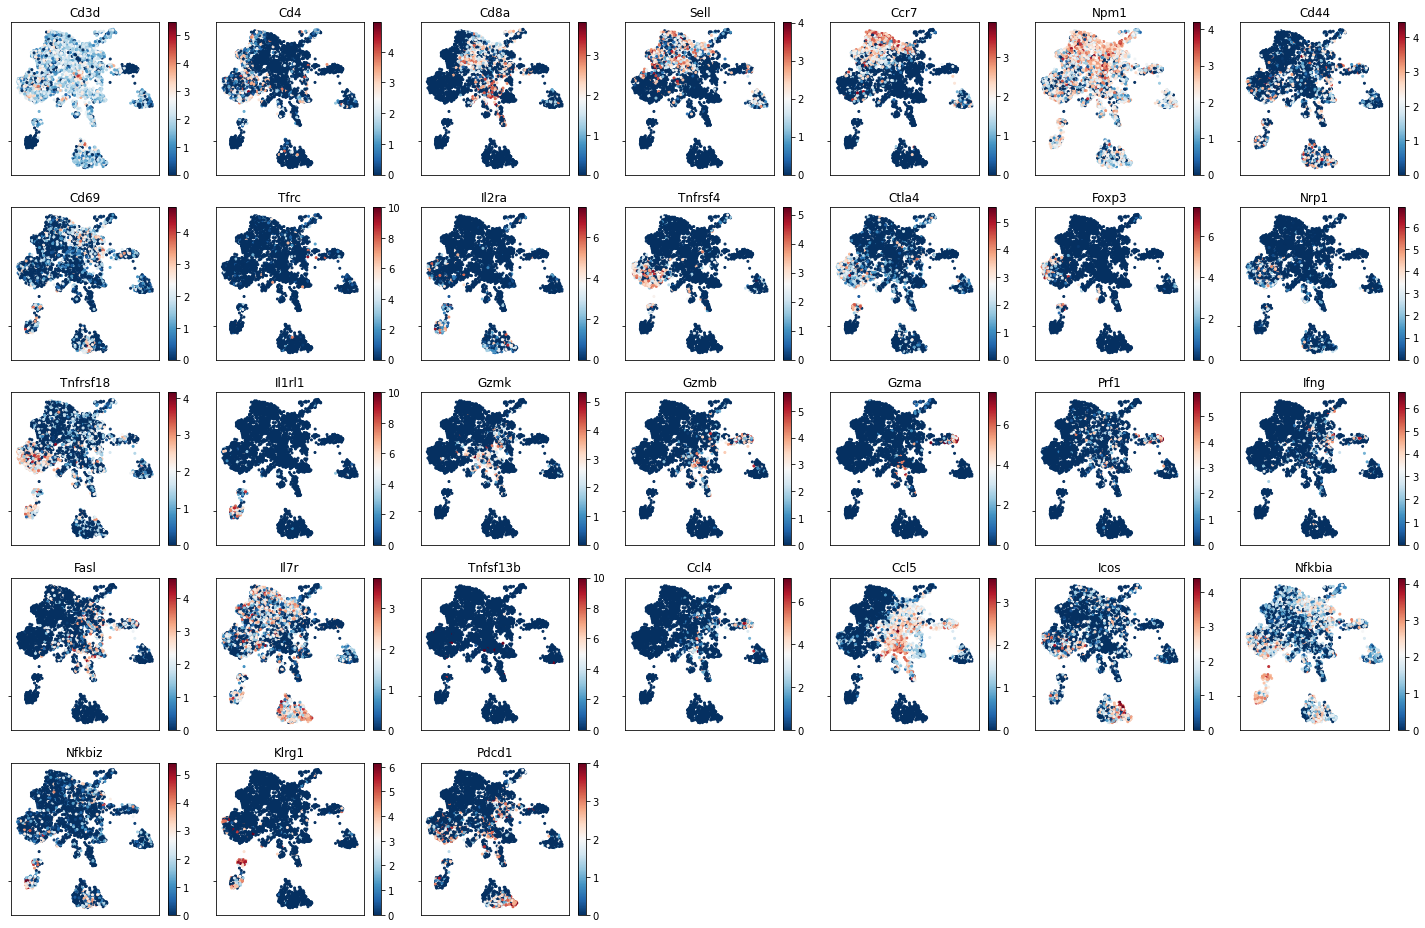

In [8]:
# Annotation info: marker gene expression
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
for gene in marker_list:
    df_plot[gene] = adata[:, gene].X.toarray()

plt.figure(figsize=[20,13])
for igene,gene in enumerate(marker_list):
    plt.subplot(5,7,igene+1)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='RdBu_r', s=4)
    plt.colorbar()
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([0],[''])
    plt.yticks([0],[''])
    plt.title(gene)

plt.tight_layout()
plt.show()

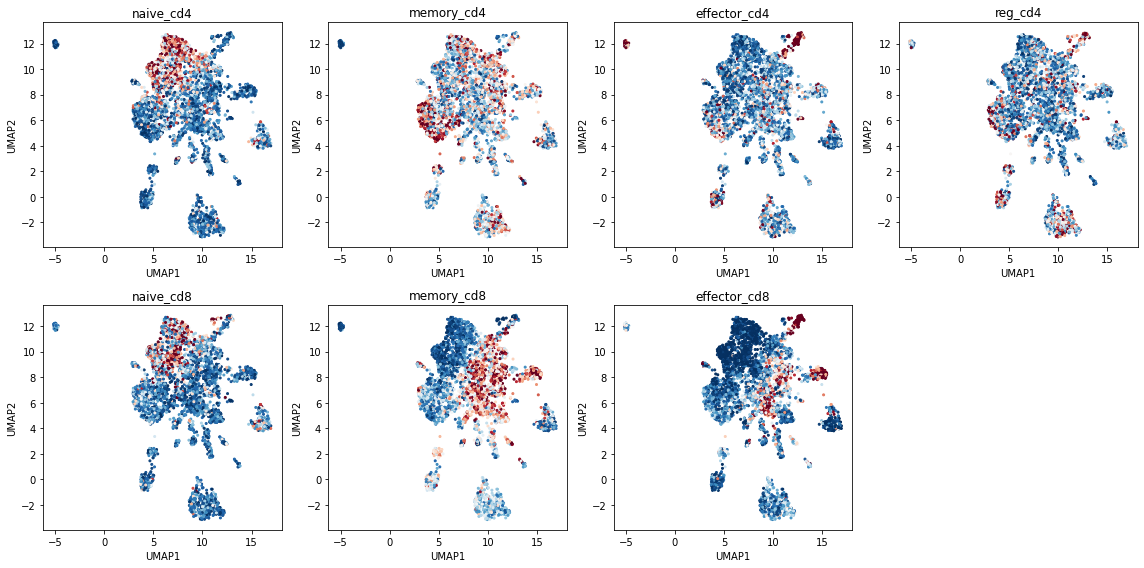

In [9]:
# Annotation info: tsig scores
adata = dic_data_proc['facs'].copy()
trait_list_plot = DIC_TRAIT_LIST['facs_tsig']
ds = 'facs'
score_name = 'facs_tsig'
nrow,ncol =2,4

plt.figure(figsize=[16, 8])
for i_trait,trait in enumerate(trait_list_plot):
    plt.subplot(nrow,ncol,i_trait+1)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[list(set(df_plot.index) & set(dic_score[score_name].index))]
    df_plot = df_plot.join(dic_score[score_name]['%s.nlog10_pval'%trait])

    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=np.quantile(df_plot['%s.nlog10_pval'%trait], q=0.95), vmin=0, s=4)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(trait)

plt.tight_layout()
plt.show()

In [32]:
# Trajectory for facs data 
adata = dic_data_proc['facs'].copy()
dic_annot = {'0': 'Cd4+ alpha-beta T cell/regulatory T cell', # Tnfrsf4 (OX40, effector), Ctla,Foxp3 (Treg)
             '1': 'Cd8+ alpha-beta T cell/mature NK T cell/mature alpha-beta T cell', # Effector Cd8 
             '2': 'Cd8+ alpha-beta T cell', # Effector Cd8
             '3': 'Cd4+/Cd8+ alpha-beta T cell', # Clearly naive 
             '4': 'Cd4+/Cd8+ alpha-beta T cell', # Clearly naive 
             '5': 'T cell', # Cd4- Cd8-, may not be typical T cells
             '6': 'Cd8+ alpha-beta T cell', # Effector Cd8, does seem to be functioning yet
             '7': 'rm', # Contains B cells and macrophage markers, suspicious
             '8': 'Cd4+ alpha-beta T cell', # Klrg1 is related to apoptosis
             '9': 'Cd4+ alpha-beta T cell/mature NK T cell', 
             '10': 'T cell', # Apoe is weird
             '11': 'T cell', # 
            }
adata.obs['leiden_anno'] = [dic_annot[x] if x in dic_annot else 'na' for x in adata.obs['leiden']]

# Remove irrelevant clusters 
print('# Before filter: n_cell=%d'%adata.shape[0])
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
adata = adata[adata.obs['leiden'].isin(cluster_list)]
adata = adata[adata.obs['leiden_anno']!='rm']
adata.obs['leiden_anno'] = adata.obs['leiden_anno'].astype('category')
print('# After filter: n_cell=%d'%adata.shape[0])

# Assign new leiden labels 
cluster_id = 0 
adata.obs['leiden_fil'] = ''
for cluster in adata.obs['leiden'].cat.categories:
    if (adata.obs['leiden']==cluster).sum()>0:
        adata.obs.loc[adata.obs['leiden']==cluster, 'leiden_fil'] = '%s'%cluster_id
        cluster_id+=1
adata.obs['leiden_fil'] = adata.obs['leiden_fil'].astype('category')
adata.obs['leiden_fil'].cat.reorder_categories(['%d'%x for x in range(len(set(adata.obs['leiden_fil'])))],
                                               inplace=True)

Trying to set attribute `.obs` of view, copying.


# Before filter: n_cell=4145
# After filter: n_cell=3769


In [34]:
# Assign dpt_cd4 and dpt_cd8
sc.tl.diffmap(adata)
root_cell = adata.obs_names[np.argmin(adata.obsm['X_umap'][:,0]+100*(adata.obs['leiden_anno']!=
                                                                     'Cd4+/Cd8+ alpha-beta T cell'))]

# Cd4 trajectory 
cluster_list = ['Cd4+ alpha-beta T cell', 
                'Cd4+ alpha-beta T cell/regulatory T cell',
                'Cd4+/Cd8+ alpha-beta T cell']
temp_data = adata[adata.obs['leiden_anno'].isin(cluster_list), :].copy()
temp_data.uns['iroot'] = np.where(temp_data.obs_names==root_cell)[0][0]
sc.tl.dpt(temp_data)
adata.obs['dpt_cd4'] = 0
adata.obs.loc[temp_data.obs_names, 'dpt_cd4'] = temp_data.obs['dpt_pseudotime']

# Cd8 trajectory
cluster_list = ['Cd4+/Cd8+ alpha-beta T cell', 
                'Cd8+ alpha-beta T cell', 
                'Cd8+ alpha-beta T cell/mature NK T cell/mature alpha-beta T cell']
temp_data = adata[adata.obs['leiden_anno'].isin(cluster_list), :].copy()
temp_data.uns['iroot'] = np.where(temp_data.obs_names==root_cell)[0][0]
sc.tl.dpt(temp_data)
adata.obs['dpt_cd8'] = 0
adata.obs.loc[temp_data.obs_names, 'dpt_cd8'] = temp_data.obs['dpt_pseudotime']

# Compute quantile normalizaed version 
def qn(x):
    v_rank = np.zeros(x.shape[0])
    v_rank[np.argsort(x)] = np.arange(x.shape[0])
    return v_rank/v_rank.shape[0]

for term in ['dpt_cd4', 'dpt_cd8']:
    ind_select = adata.obs[term]>0
    adata.obs['%s_qn'%term] = 0
    adata.obs.loc[ind_select, '%s_qn'%term] = qn(adata.obs.loc[ind_select, term])
    
adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
            'tcell.facs.annot.h5ad')

### Check correlation with DPT 

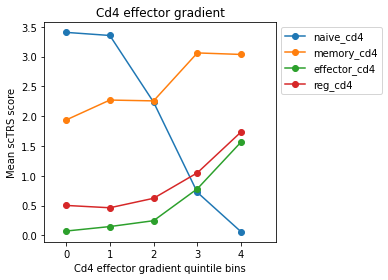

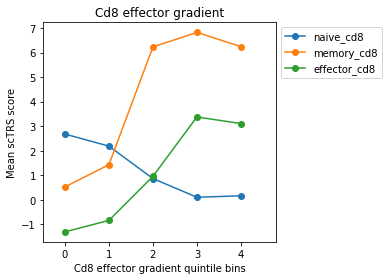

In [35]:
# T signatures
trait_list_plot = sorted([x.replace('.raw_score','') for x in dic_score['facs_tsig'].columns if 'raw_score' in x])

plot_list = [['dpt_cd4_qn', ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']],
             ['dpt_cd8_qn', ['naive_cd8', 'memory_cd8', 'effector_cd8']], 
            ]

ds = 'facs_tsig'
dic_title = {'dpt_cd4_qn': 'Cd4 effector gradient', 
             'dpt_cd8_qn': 'Cd8 effector gradient'}
nrow,ncol =2,4
for i_plot,temp_list in enumerate(plot_list):
    term,sig_list = temp_list
    df_plot = adata.obs[[term]].copy()
    df_plot = df_plot.loc[df_plot[term]>0]
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, ['%s.norm_score'%x for x in sig_list]])
    df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
    
    plt.figure(figsize=[5.5,4])
    i_color = 0
    for sig in sig_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%sig: [np.mean, np.std]})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%sig]['mean'], 'o-', label=sig, color='C%d'%i_color)
#         plt.text(4.2, temp_df['%s.norm_score'%sig]['mean'][4], df_stats.loc['%s.%s'%(term,sig),'P_STR'],
#                  color='C%d'%i_color)
        i_color+=1
    
    plt.xlim([-0.5,4.8])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.ylabel('Mean scTRS score')
    plt.title(dic_title[term])
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%term)
    plt.show()